# Factor NaN Report

Visualize NaN rates in factor parquet files.

In [1]:
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Optional: set repo root manually if auto-detect fails
# Example: repo_root = Path('C:/Users/BaiYang/CBOND_DAY')
repo_root = None

root = Path.cwd()
if repo_root is None:
    while root != root.parent and not (root / 'cbond_daily').exists():
        root = root.parent
    if not (root / 'cbond_daily').exists():
        raise FileNotFoundError('Cannot find repo root containing cbond_daily. Set repo_root explicitly.')
else:
    root = repo_root

# Load paths_config.json5 (minimal parsing)
paths_cfg = root / 'cbond_daily' / 'config' / 'paths_config.json5'
text = paths_cfg.read_text(encoding='utf-8')

# Extract dws_root value from JSON5-like config
m = re.search(r'dws_root\s*:\s*"([^"]+)"', text)
if not m:
    raise ValueError('Cannot parse dws_root from paths_config.json5')

factor_root = Path(m.group(1))
print('factor_root:', factor_root)


factor_root: D:\cbond_daily\factor_data


In [2]:
# Scan factor parquet files
files = sorted(factor_root.rglob('*.parquet'))
print('parquet files:', len(files))

# Optionally limit to recent files
recent_n = 30
files_recent = files[-recent_n:] if len(files) > recent_n else files
print('recent files:', len(files_recent))

# Collect NaN rates per file
rows = []
for f in files_recent:
    df = pd.read_parquet(f)
    # identify factor columns
    factor_cols = [c for c in df.columns if c not in ('trade_date','code','instrument_code','exchange_code')]
    if not factor_cols:
        continue
    nan_rate = df[factor_cols].isna().mean()
    trade_date = f.stem  # yyyymmdd
    rows.append(pd.DataFrame({'factor': nan_rate.index, 'nan_rate': nan_rate.values, 'trade_date': trade_date}))

if not rows:
    raise SystemExit('No factor columns found')

nan_df = pd.concat(rows, ignore_index=True)
print('rows:', len(nan_df))


parquet files: 494
recent files: 30
rows: 480


In [3]:
# Overall NaN rate by factor (average)
summary = nan_df.groupby('factor', as_index=False)['nan_rate'].mean().sort_values('nan_rate', ascending=False)
summary.head(20)


,factor,nan_rate
16,trend_prem_lag_simple_0.5_20_5_,0.897452
9,option_cheapness_252_1e-08_0.5_0.3_20_,0.548331
11,rolling_max_drawdown_28_,0.409712
14,rolling_ret_vol_28_,0.409712
10,rolling_max_drawdown_14_,0.406434
13,rolling_ret_vol_14_,0.406434
5,expr_alpha_001_9_60_15_8_6_20_,0.405323
15,rolling_ret_vol_7_,0.404267
12,rolling_max_drawdown_7_,0.404267
0,carry_cheapness_0.2_True_,0.402260


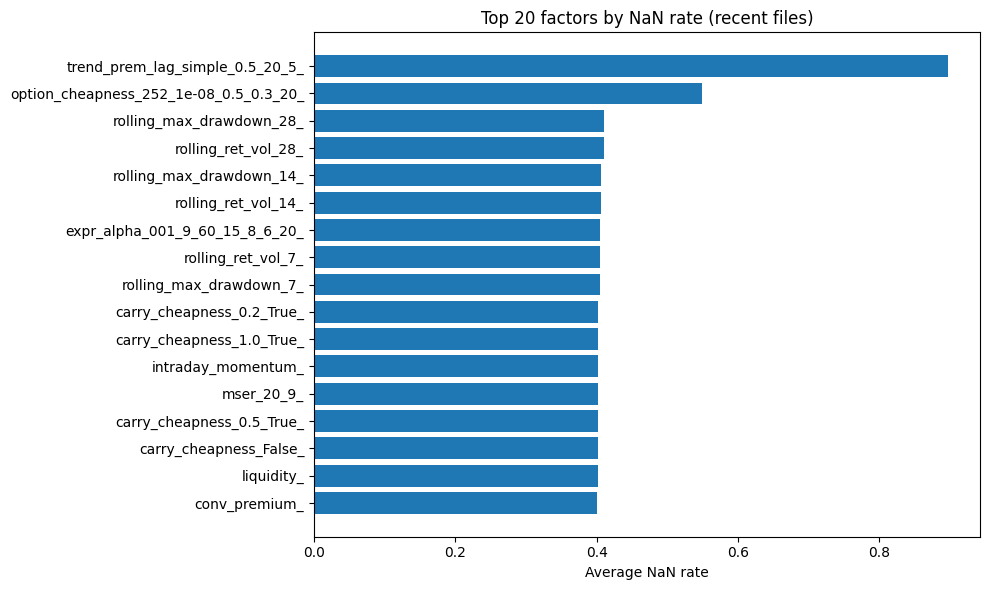

In [4]:
# Plot top 20 factors by NaN rate
plt.figure(figsize=(10, 6))
head = summary.head(20)
plt.barh(head['factor'][::-1], head['nan_rate'][::-1])
plt.xlabel('Average NaN rate')
plt.title('Top 20 factors by NaN rate (recent files)')
plt.tight_layout()
plt.show()


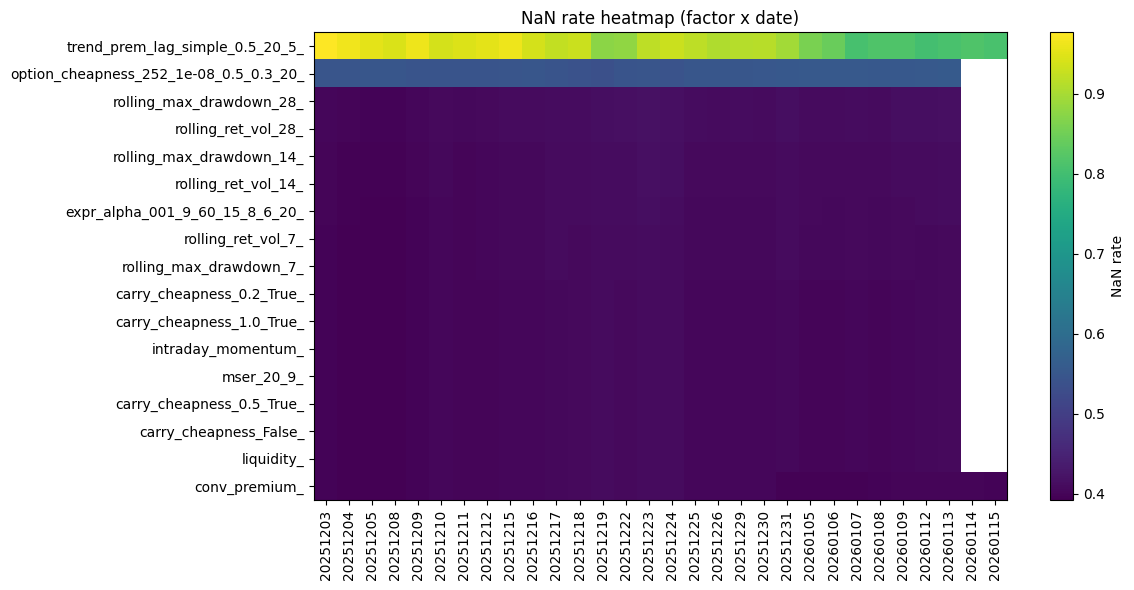

In [5]:
# Heatmap: factors vs dates (NaN rate)
# pivot to matrix
pivot = nan_df.pivot_table(index='factor', columns='trade_date', values='nan_rate')
# show only factors with any NaN
pivot = pivot.loc[pivot.mean(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(12, max(6, 0.3 * len(pivot))))
plt.imshow(pivot.values, aspect='auto', interpolation='nearest')
plt.colorbar(label='NaN rate')
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=90)
plt.title('NaN rate heatmap (factor x date)')
plt.tight_layout()
plt.show()


## View Factors on a Specific Date

In [6]:
# View factor values for a specific date
# date format: YYYYMMDD
view_date = '20260115'

# find parquet for that date
parquet_path = None
for p in factor_root.rglob(f"{view_date}.parquet"):
    parquet_path = p
    break

if parquet_path is None:
    raise FileNotFoundError(f'No parquet found for {view_date} under {factor_root}')

print('using', parquet_path)
df = pd.read_parquet(parquet_path)

# show a few rows and all factor columns
id_cols = ['trade_date', 'code', 'instrument_code', 'exchange_code']
existing_id_cols = [c for c in id_cols if c in df.columns]
factor_cols = [c for c in df.columns if c not in id_cols]

print('id columns:', existing_id_cols)
print('factor columns:', len(factor_cols))

display(df[existing_id_cols + factor_cols].head())
df

using D:\cbond_daily\factor_data\2026-01\20260115.parquet
id columns: ['trade_date', 'code']
factor columns: 2


,trade_date,code,trend_prem_lag_simple_0.5_20_5_,conv_premium_
0,2026-01-15,110067.SH,0.231605,9.222407
1,2026-01-15,110070.SH,0.007692,15.617216
2,2026-01-15,110073.SH,0.040129,38.948670
3,2026-01-15,110074.SH,4.743947,14.788665
4,2026-01-15,110075.SH,0.400572,10.470004


,trade_date,code,trend_prem_lag_simple_0.5_20_5_,conv_premium_
0,2026-01-15,110067.SH,0.231605,9.222407
1,2026-01-15,110070.SH,0.007692,15.617216
2,2026-01-15,110073.SH,0.040129,38.948670
3,2026-01-15,110074.SH,4.743947,14.788665
4,2026-01-15,110075.SH,0.400572,10.470004
...,...,...,...,...
631,2026-01-15,128136.SZ,NaN,35.017256
632,2026-01-15,128137.SZ,NaN,22.306046
633,2026-01-15,128138.SZ,0.064245,66.917500
634,2026-01-15,128141.SZ,NaN,13.856297
